In [4]:
import matplotlib.pyplot as plt
import numpy as np
#单峰需求定义
def q2_var(step):
    if step<5*600:
        return 40+step*20/3000
    elif step<20*600:
        return 60
    elif step<25*600:
        return 60-(step-20*600)*20/3000
    else:return 40
def q1_var(step):
    if step<5*600:
        return 5+step*5/3000
    elif step<20*600:
        return 10
    elif step<25*600:
        return 10-(step-20*600)*5/3000
    else:return 5

mkdir /kaggle/working/python_file

In [15]:
import math
import numpy as np
import random

class PointQueueEnv():
    def __init__(self, name, demand = "constant"):
        self.lambda1 = 0
        self.lambda2 = 2
        self.q1, self.C1 = 5.0, 30.0
        self.q2, self.C2 = 40.0, 30.0
        self.g1 = 5
        self.g2 = 30
        self.q3 = 0
        self.u = math.log(2)
        self.CumLambda1 = 0
        self.CumG1 = 0
        self.step = 0
        self.model_name = name
        # self.state = [self.lambda1/200.0, self.lambda2/500.0, self.q1/10.0, self.q2/60.0, self.q3/60.0]
        self.state = np.array([self.lambda1 / 200.0, self.lambda2 / 500.0, self.q1 / 10.0, self.q2 / 60.0, self.q3 / 60.0], dtype=np.float32)
        self.demand = demand
        self.w_dif = self.lambda2 / self.C2 - self.lambda1 / self.C1
        
        self.CT=0
        self.TSTT=0



        self.lambda1L = []
        self.lambda2L = []
        self.q1L, self.C1L = [], []
        self.q2L, self.C2L = [], []
        self.q3L = []
        self.uL = []
        self.g1L, self.g2L = [], []
        self.w_difL = []

    def calCapacity(self):
        if self.lambda1 == 0:
            self.C1 = 30
        else:
            self.C1 = 30 * (1 - 0.1)
        if self.lambda2 == 0:
            self.C2 = 30
        else:
            self.C2 = 30 * (1 - 0.1)

    def calQnum(self):
        self.lambda1 = max((self.q1 + self.q3 - self.C1) / 600.0 + self.lambda1, 0)
        self.lambda2 = max((self.q2 - self.q3 - self.C2) / 600.0 + self.lambda2, 0)
        self.CumLambda1 += self.lambda1
        self.lambda1L.append(self.lambda1)
        self.lambda2L.append(self.lambda2)

    def calOutflow(self):
        self.g1 = min(self.q1 + self.q3+1000000000*self.lambda1, self.C1)/600
        self.g2 = min(self.q2 - self.q3+1000000000*self.lambda1, self.C2)/600
        self.g1L.append(self.g1)
        self.g2L.append(self.g2)
        self.CumG1 += self.g1

    def calTimeDif(self):
        self.w_dif = self.lambda2 / self.C2 - self.lambda1 / self.C1
        self.w_difL.append(self.w_dif)

    def calQ3(self):
        if self.model_name == "logit_rand":
            alpha = 10
            pi = 0.5
            rand = random.uniform(-0.1, 0.1)
            self.q3 = self.q2 / (1 + math.exp(alpha * (self.u - (1+rand) * pi * self.w_dif)))
            self.q3L.append(self.q3)
        if self.model_name == "logit":
            alpha = 1
            pi = 0.5
            self.q3 = self.q2 / (1 + math.exp(alpha * (self.u -  pi * self.w_dif)))
            self.q3L.append(self.q3)
        if self.model_name == "UE":
            pi = 0.5
            if self.w_dif == 0.0:
                if self.u == 0:
                    self.q3 = self.q2 * (self.C1 - self.q1) / (self.C1 - self.q1 + self.C2)
                else:
                    self.q3 = 0
            if self.w_dif != 0.0:
                if self.w_dif<0:
                    self.q3 = 0
                else:
                    try:
                        self.q3 = self.q2 / math.exp(self.u / (pi * self.w_dif))
                    except OverflowError:
                        self.q3 = 0
                        # print("OverflowError")
            self.q3L.append(self.q3)

    def setPrice(self, price):
        self.u = price


    def getDemand(self, i):
        # self.q1 = max(2, min(i / 30.0, 10, (40 - i / 30.0)))
        # self.q2 = max(31, min(i / 5.0, 60, (240 - i / 5.0)))
        if self.demand == 'constant':
            self.q1 = 10
            self.q2 = 60
        elif self.demand == 'random':
            self.q1 = np.random.poisson(lam=10)
            self.q2 = np.random.poisson(lam=60)
        elif self.demand =='var1':
            self.q1=q1_var(self.step)
            self.q2=q2_var(self.step)
            pass
        self.q1L.append(self.q1)
        self.q2L.append(self.q2)


    def update(self):
        ###whether capacity drop
        # self.calCapacity()
        self.getDemand(self.step)
        self.calTimeDif()
        self.calQ3()
        self.calQnum()
        self.calOutflow()
        self.uL.append(self.u)
        self.R=self.u[0]*self.q3*0.1/60
        self.ToR+=self.R
        
        self.CT=(self.lambda1*self.q1+self.lambda2*(self.q2-self.q3))*0.1/60
        self.TSTT+=self.CT
        self.step += 1
    
    def getdone(self):
        if self.step>=18000:
            return True
        # if self.lambda1>5:
        #     return True
        return False

    def reset(self):
        self.lambda1 = 0
        self.lambda2 = 2
        self.q1, self.C1 = 5.0, 30.0
        self.q2, self.C2 = 40.0, 30.0
        self.g1 = 5
        self.g2 = 30
        self.q3 = 0
        self.u = math.log(2)
        self.CumLambda1 = 0
        self.CumG1 = 0
        self.step = 0
        self.R=0
        self.ToR=0
        self.CT=0
        self.TSTT=0
        

        self.lambda1L = []
        self.lambda2L = []
        self.q1L, self.C1L = [], []
        self.q2L, self.C2L = [], []
        self.q3L = []
        self.uL = []
        self.g1L, self.g2L = [], []
        self.w_difL = []

    def getList(self):
        return self.lambda1L, self.lambda2L, self.q1L, self.C1L, self.q2L, self.C2L, self.q3L, self.uL, self.g1L, self.g2L, self.w_difL

    # def getState(self):
    #     stdLambda1 = self.lambda1/200.0
    #     stdLambda2 = self.lambda2/500.0
    #     stdQ1 = self.q1/10.0
    #     stdQ3 = self.q3/30.0
    #     stdG1 = self.g1/30.0
    #     stdG2 = self.g2/30.0
    #     s = np.array([stdLambda1, stdLambda2], dtype=np.float32)
    #     # s = np.array([stdLambda1, stdLambda2, stdQ1, stdQ3, stdG1, stdG2], dtype=np.float32)
    #     return s
    ###time-dependant demands
    def getState(self):
        stdLambda1 = self.lambda1/100
        stdLambda2 = self.lambda2/300
        stdQ1 = self.q1/20
        stdQ2 = self.q2/70
        stdQ3= self.q3/70
        stdG1=self.g1/30.0
        stdG2 = self.g2 /30.0

        s = np.array([stdLambda1, stdLambda2, stdQ1, stdQ2, stdQ3], dtype=np.float32)
        # s = np.array([stdLambda1, stdLambda2, stdQ1, stdQ3, stdG1, stdG2], dtype=np.float32)
        return s

    def getReward(self):
        self.reward = max(-10000, (self.g1+self.g2-0.4*self.lambda1))/1200             ###最大化吞吐量
#         self.reward= max(-1,self.R-0.015*self.lambda1)/1200                  ###收益最大化
#         self.reward=(10-self.CT-1.3*self.lambda1)/1200                        #最小化TSTT
        # self.reward = max(-1, (self.g1 - 5*self.lambda1)/30.0)
        # self.reward = self.g1/30 - 100 * self.lambda1/200
        # self.reward = self.g1 - 5*self.lambda1  #3,4,5 did not work
        # if self.g1==30 and self.lambda1 == 0:
        #     self.reward += 30
        # self.reward = (self.CumG1) - (self.CumLambda1)
        # self.reward = self.g1 - 10 * math.log(self.lambda1 + 1)
        return self.reward

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import collections
import random
 
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(888)
# ------------------------------------- #
# 经验回放池
# ------------------------------------- #
 
class ReplayBuffer:
    def __init__(self, capacity):  # 经验池的最大容量
        # 创建一个队列，先进先出
        self.buffer = collections.deque(maxlen=capacity)
    # 在队列中添加数据
    def add(self, state, action, reward, next_state, done):
        # 以list类型保存
        self.buffer.append((state, action, reward, next_state, done))
    # 在队列中随机取样batch_size组数据
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        # 将数据集拆分开来
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    # 测量当前时刻的队列长度
    def size(self):
        return len(self.buffer)
 
# ------------------------------------- #
# 策略网络
# ------------------------------------- #
 
class PolicyNet(nn.Module):
    def __init__(self, n_states, n_hiddens, n_actions, action_bound):
        super(PolicyNet, self).__init__()
        # 环境可以接受的动作最大值
        self.action_bound = action_bound
        # 只包含一个隐含层
        self.fc1 = nn.Linear(n_states, n_hiddens)

        self.fc2 = nn.Linear(n_hiddens, n_actions)
    # 前向传播
    def forward(self, x):
        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # [b,n_hiddens]-->[b,n_actions]
        x= torch.tanh(x)  # 将数值调整到 [-1,1]
        x = x * self.action_bound  # 缩放到 [-action_bound, action_bound]
        return x
 
# ------------------------------------- #
# 价值网络
# ------------------------------------- #
 
class QValueNet(nn.Module):
    def __init__(self, n_states, n_hiddens, n_actions):
        super(QValueNet, self).__init__()
        # 
        self.fc1 = nn.Linear(n_states + n_actions, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, 1)
    # 前向传播
    def forward(self, x, a):
        # 拼接状态和动作
        cat = torch.cat([x, a], dim=1)  # [b, n_states + n_actions]
        x = self.fc1(cat)  # -->[b, n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # -->[b, n_hiddens]
        x = F.relu(x)
        x = self.fc3(x)  # -->[b, 1]
        return x
 
# ------------------------------------- #
# 算法主体
# ------------------------------------- #
#from OU_Noise import OUNoise

class DDPG:
    def __init__(self, n_states, n_hiddens, n_actions, action_bound,
                 sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actorloss=[]
        self.criticloss=[]
        # 策略网络--训练
        self.actor = PolicyNet(n_states, n_hiddens, n_actions, action_bound).to(device)
        # 价值网络--训练
        self.critic = QValueNet(n_states, n_hiddens, n_actions).to(device)
        # 策略网络--目标
        self.target_actor = PolicyNet(n_states, n_hiddens, n_actions, action_bound).to(device)
        # 价值网络--目标
        self.target_critic = QValueNet(n_states, n_hiddens, n_actions).to(device
                                                                          )
        # 初始化价值网络的参数，两个价值网络的参数相同
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化策略网络的参数，两个策略网络的参数相同
        self.target_actor.load_state_dict(self.actor.state_dict())
 
        # 策略网络的优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        # 价值网络的优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
 
        # 属性分配
        self.gamma = gamma  # 折扣因子
        self.sigma = sigma  # 高斯噪声的标准差，均值设为0
        self.tau = tau  # 目标网络的软更新参数
        self.n_actions = n_actions
        self.device = device
 
    # 动作选择
    def take_action(self, state,i=1):
        # 维度变换 list[n_states]-->tensor[1,n_states]-->gpu
        state = torch.tensor(state, dtype=torch.float).view(1,-1).to(self.device)
        # 策略网络计算出当前状态下的动作价值 [1,n_states]-->[1,1]-->int
        action = self.actor(state).item()
        # 给动作添加噪声，增加搜索
        action = action + self.sigma * np.random.randn(self.n_actions)*i
        # action+=self.exploration_noise.noise()*i
        return action
    
    # 软更新, 意思是每次learn的时候更新部分参数
    def soft_update(self, net, target_net):
        # 获取训练网络和目标网络需要更新的参数
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            # 训练网络的参数更新要综合考虑目标网络和训练网络
            param_target.data.copy_(param_target.data*(1-self.tau) + param.data*self.tau)
 
    # 训练
    def update(self, transition_dict):
        # 从训练集中取出数据
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)  # [b,n_states]
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.float).view(-1,1).to(self.device)  # [b,1]
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1,1).to(self.device)  # [b,1]
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)  # [b,next_states]
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1,1).to(self.device)  # [b,1]
        
        # 价值目标网络获取下一时刻的动作[b,n_states]-->[b,n_actors]
        next_q_values = self.target_actor(next_states)
        # 策略目标网络获取下一时刻状态选出的动作价值 [b,n_states+n_actions]-->[b,1]
        next_q_values = self.target_critic(next_states, next_q_values)
        # 当前时刻的动作价值的目标值 [b,1]
        q_targets = rewards + self.gamma * next_q_values * (1-dones)
        
        # 当前时刻动作价值的预测值 [b,n_states+n_actions]-->[b,1]
        q_values = self.critic(states, actions)
 
        # 预测值和目标值之间的均方差损失
        critic_loss = torch.mean(F.mse_loss(q_values, q_targets))
        # 价值网络梯度
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
 
        # 当前状态的每个动作的价值 [b, n_actions]
        actor_q_values = self.actor(states)
        # 当前状态选出的动作价值 [b,1]
        score = self.critic(states, actor_q_values)
        # 计算损失
        actor_loss = -torch.mean(score)
        # 策略网络梯度
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
 
        # 软更新策略网络的参数  
        self.soft_update(self.actor, self.target_actor)
        # 软更新价值网络的参数
        self.soft_update(self.critic, self.target_critic)
        self.actorloss.append(actor_loss.item())
        self.criticloss.append(critic_loss.item())
        

if __name__=='__main__':
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import gym
    device = torch.device('cuda') 
    
    # -------------------------------------- #
    # 环境加载
    # -------------------------------------- #
    
    # env_name = "MountainCarContinuous-v0"  # 连续型动作
    # env = gym.make(env_name, render_mode="human")

    n_states = 5  # 状态数 2
    n_actions = 1  # 动作数 1
    action_bound = 1  # 堆成动作的最大值 1.0
    
    # -------------------------------------- #
    # 模型构建
    # -------------------------------------- #
    
    # 经验回放池实例化
    buffer_size=1000*100000
    replay_buffer = ReplayBuffer(capacity=buffer_size)
    # 模型实例化
    n_hiddens=128
    abound=1
    sigma=0.3
    actor_lr=1e-3
    critic_lr=2e-3
    tau=0.02
    gamma=0.99
    min_size=10000
    batch_size=64
    agent = DDPG(n_states = n_states,  # 状态数
                n_hiddens = n_hiddens,  # 隐含层数
                n_actions = n_actions,  # 动作数
                action_bound = abound,  # 动作最大值
                sigma = sigma,  # 高斯噪声
                actor_lr = actor_lr,  # 策略网络学习率
                critic_lr = critic_lr,  # 价值网络学习率
                tau = tau,  # 软更新系数
                gamma = gamma,  # 折扣因子
                device = device
                )
    
    # -------------------------------------- #
    # 模型训练
    # -------------------------------------- #
    
    return_list = []  # 记录每个回合的return
    mean_return_list = []  # 记录每个回合的return均值
#     import environment
    max_step=120
    env=PointQueueEnv('logit')
    for i in range(1000):  # 迭代200回合
        agent.sigma=agent.sigma*0.999
        episode_return = 0  # 累计每条链上的reward
        env.reset()  # 初始时的状态
        state=env.getState()
        done = False  # 回合结束标记
        count=0
        while not done:
            count+=1
            # 获取当前状态对应的动作
            action = agent.take_action(state)
            action = np.clip(action, -1, 1)
            pr=action*7.5+7.5
            env.setPrice(pr)
            rwd_=0.0
            for j in range(120):
                env.update()
                rwd_+=env.getReward()
            # 环境更新
            next_state=env.getState()
            reward=rwd_
            done=env.getdone()
            # 更新经验回放池
            replay_buffer.add(state, action, reward, next_state, done)
            # 状态更新
            state = next_state
            # 累计每一步的reward
            episode_return += reward
    
            # 如果经验池超过容量，开始训练
            if replay_buffer.size() > min_size:
                # 经验池随机采样batch_size组
                s, a, r, ns, d = replay_buffer.sample(batch_size)
                # 构造数据集
                transition_dict = {
                    'states': s,
                    'actions': a,
                    'rewards': r,
                    'next_states': ns,
                    'dones': d,
                }
                # 模型训练
                agent.update(transition_dict)
        
        # 保存每一个回合的回报
        return_list.append(episode_return)
        mean_return_list.append(np.mean(return_list[-10:]))  # 平滑

        if i%1==0:
        # 打印回合信息
            print(f'iter:{i}, return:{episode_return}, mean_return:{np.mean(return_list[-10:])}')
        if i%50==0:
            print(f':CumG1{env.CumG1},  CumLAM1:{env.CumLambda1}')
        if episode_return>1.3:
            print(f'iter:{i}, return:{episode_return}, mean_return:{np.mean(return_list[-10:])}')
            plt.figure(figsize=(15, 9))
            plt.subplot(2, 2, 1)
            plt.plot(env.lambda1L, '-', lw=2)            
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            # 设置坐标标签字体大小
            plt.xlabel(...,fontsize=18)
            plt.ylabel(...,fontsize=18)
            plt.xlabel('time step (0.1s)')
            plt.ylabel('queue number (veh)')
            plt.title('Queue number of the HOT lane',fontsize=18)

            plt.grid(True)

            plt.subplot(2, 2, 2)
            plt.plot(env.lambda2L, '-', lw=2)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            # 设置坐标标签字体大小
            plt.xlabel(...,fontsize=18)
            plt.ylabel(...,fontsize=18)
            plt.xlabel('time step (0.1s)')
            plt.ylabel('queue number (veh)')
            plt.title('Queue number of the GP lanes',fontsize=18)
            plt.grid(True)

            plt.subplot(2, 2, 3)
            plt.plot(env.q3L, '-', lw=2)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            # 设置坐标标签字体大小
            plt.xlabel(...,fontsize=18)
            plt.ylabel(...,fontsize=18)
            plt.xlabel('time step (0.1s)')
            plt.ylabel('flow rate (veh/min)')
            plt.title('Flow rate of SOVs using the HOT lane',fontsize=18)
            plt.grid(True)

            plt.subplot(2, 2, 4)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            # 设置坐标标签字体大小
            plt.xlabel(...,fontsize=18)
            plt.ylabel(...,fontsize=18)
            plt.plot(env.uL, '-', lw=2)
            plt.xlabel('time step (0.1s)',fontsize=18)
            plt.ylabel('price (dollar)')
            plt.title('Price',fontsize=18)
            plt.grid(True)

#             plt.subplot(2, 3, 5)
#             plt.plot(env.g1L, '-', lw=2)
#             plt.xlabel('time step (0.1s)')
#             plt.ylabel('flow rate (veh/min)')
#             plt.title('Throughput on the HOT lane')
#             plt.grid(True)

#             plt.subplot(2, 3, 6)
#             plt.plot(env.g2L, '-', lw=2)
#             plt.xlabel('time step (0.1s)')
#             plt.ylabel('Flow rate (veh/min)')
#             plt.title('Throughput on the GP lanes')
#             plt.grid(True)

            # plt.subplot(3, 3, 7)
            # plt.plot(q1L, '-', lw=2)
            # plt.ylabel('demand of SOV (veh/min)')
            # plt.title('q1')
            # plt.grid(True)
            #
            # plt.subplot(3, 3, 8)
            # plt.plot(q2L, '-', lw=2)
            # plt.ylabel('demand of HOV (veh/min)')
            # plt.title('q2')
            # plt.grid(True)
            print('画图')
            plt.tight_layout()
            plt.savefig(f'./TSTT/{i}.png')
            plt.close()



    # 关闭动画窗格
    # -------------------------------------- #
    # 绘图
    # -------------------------------------- #
    
    # x_range = list(range(len(return_list)))
    
    # plt.subplot(121)
    # plt.plot(x_range, return_list)  # 每个回合return
    # plt.xlabel('episode')
    # plt.ylabel('return')
    # plt.subplot(122)
    # plt.plot(x_range, mean_return_list)  # 每回合return均值
    # plt.xlabel('episode')
    # plt.ylabel('mean_return')

iter:0, return:-11.978780686942292, mean_return:-11.978780686942292
:CumG1599.1389893373624,  CumLAM1:39671.571178210856
iter:1, return:-20.056795241304346, mean_return:-16.01778796412332
iter:2, return:-22.77448096035194, mean_return:-18.270018962866192
iter:3, return:-33.7406966652696, mean_return:-22.137688388467048
iter:4, return:-12.299876303875353, mean_return:-20.170125971548707
iter:5, return:-12.126986769569344, mean_return:-18.829602771218813
iter:6, return:-11.367765754046147, mean_return:-17.76362605447986
iter:7, return:-14.421027963122286, mean_return:-17.345801293060163
iter:8, return:-16.082430432606948, mean_return:-17.205426753009803
iter:9, return:-18.767239251938786, mean_return:-17.361608002902702
iter:10, return:-46.962577881458564, mean_return:-20.85998772235433
iter:11, return:-7.173949671283488, mean_return:-19.571703165352243
iter:12, return:-25.71758365367758, mean_return:-19.86601343468481
iter:13, return:-16.368764577461572, mean_return:-18.128820225904004


KeyboardInterrupt: 

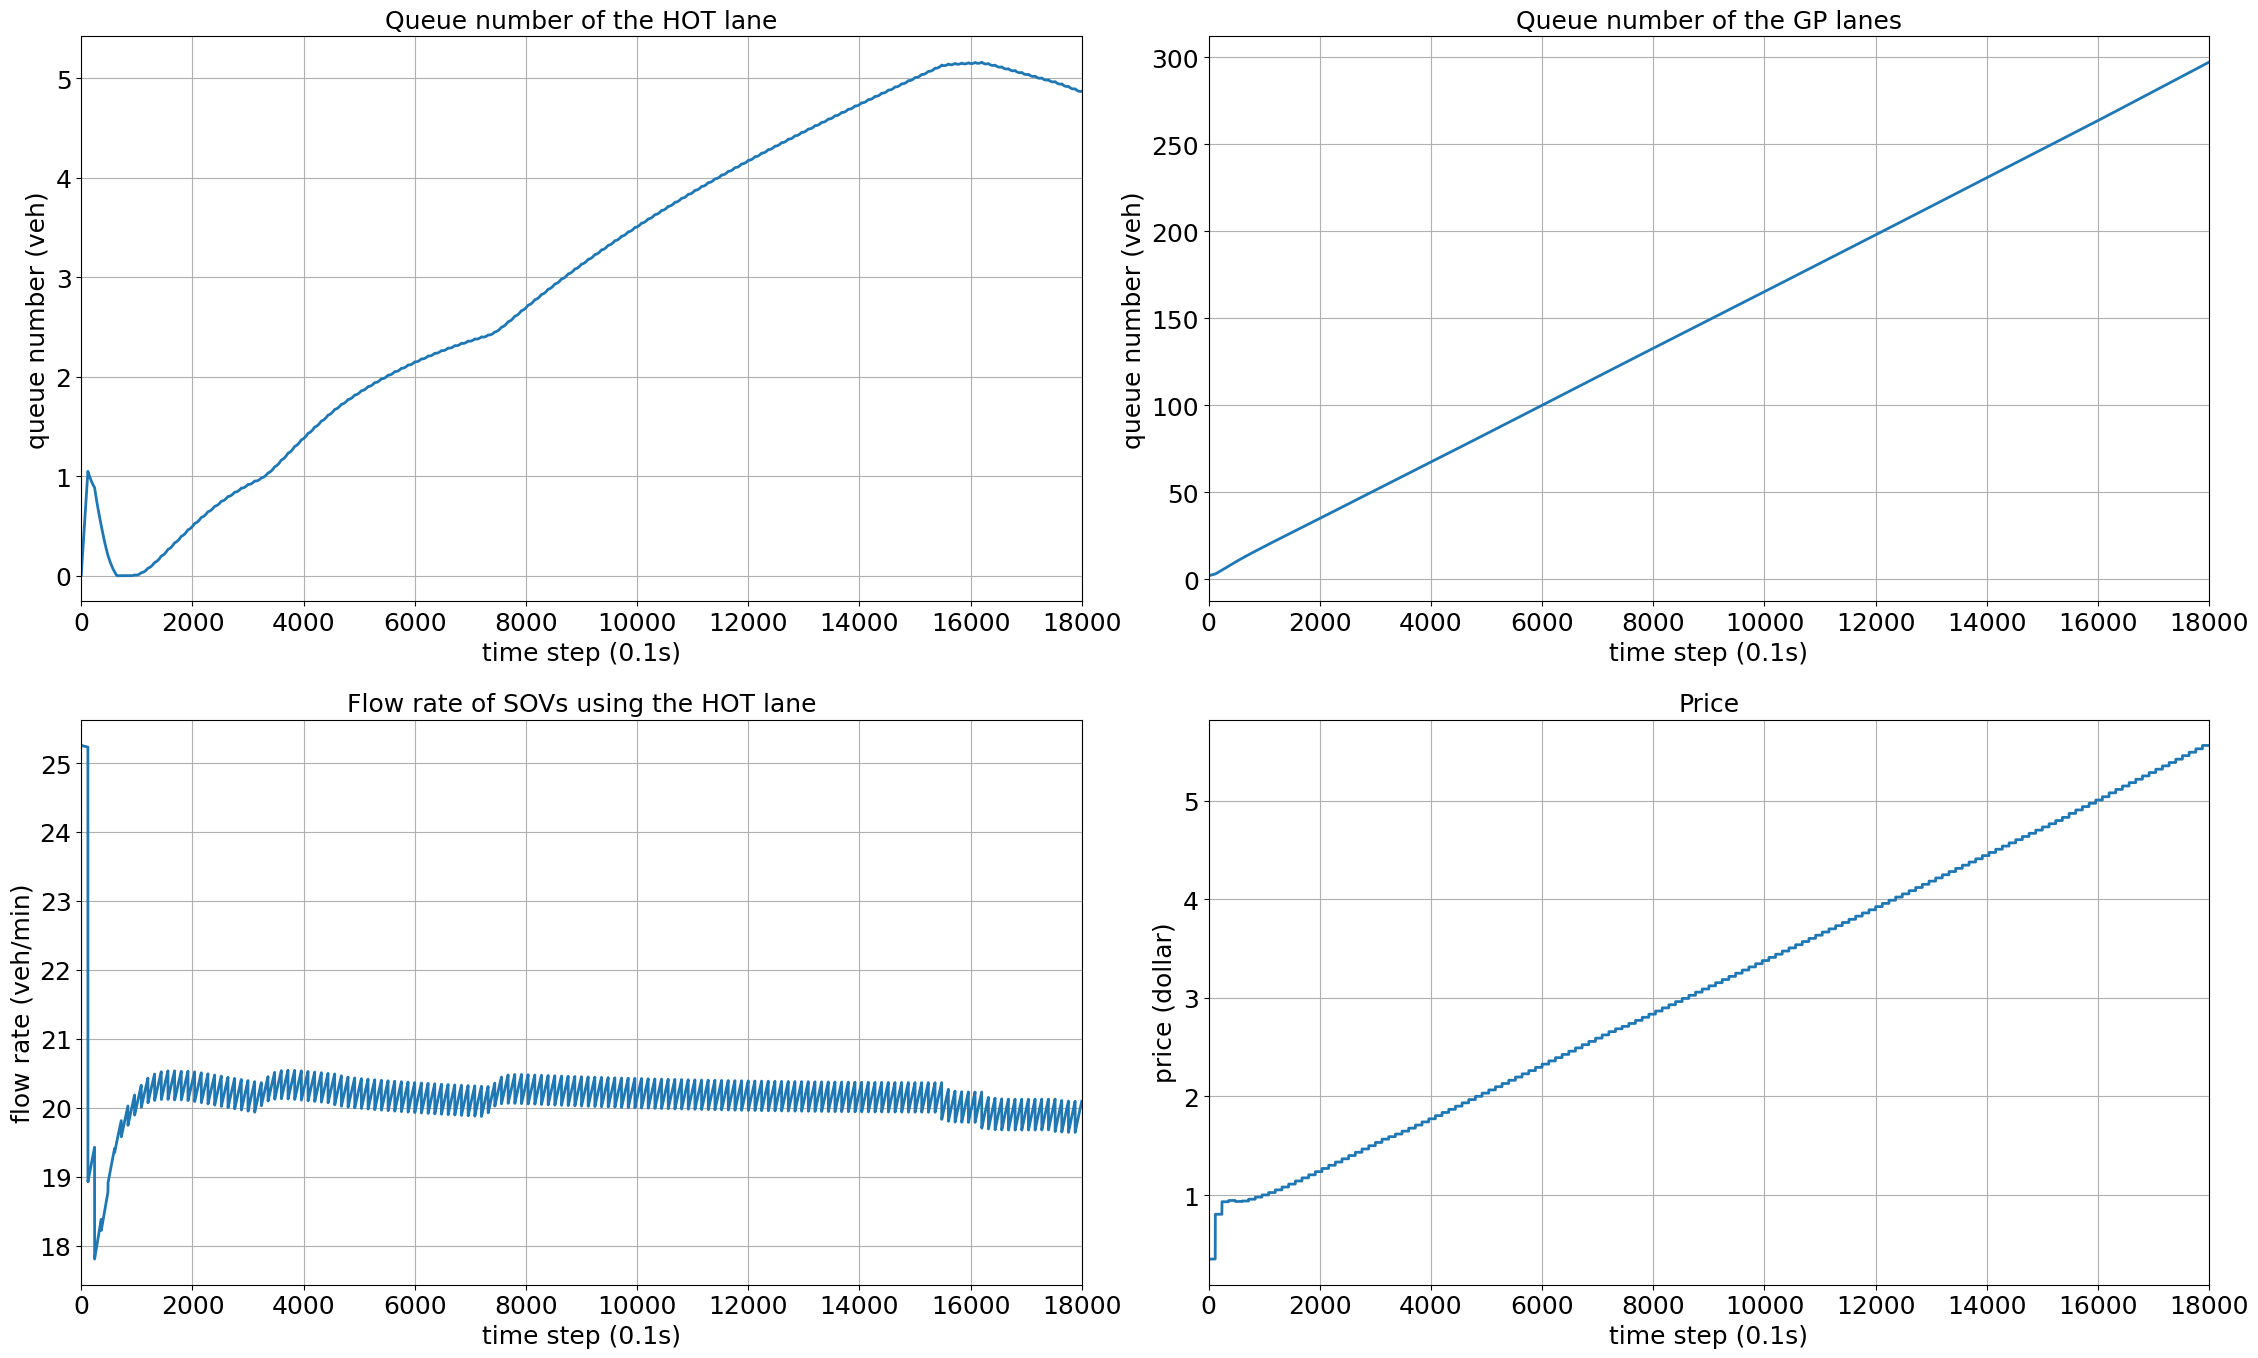

In [16]:
env=PointQueueEnv('logit')
episode_return = 0  # 累计每条链上的reward
env.reset()  # 初始时的状态
state=env.getState()
done = False  # 回合结束标记
count=0
while not done:
    count+=1
    # 获取当前状态对应的动作
    action = agent.take_action(state,i=0)
    action = np.clip(action, -1, 1)
    pr=action*5+5
    env.setPrice(pr)
    rwd_=0.0
    for j in range(120):
        env.update()
        rwd_+=env.getReward()
    # 环境更新
    next_state=env.getState()
    reward=rwd_
    done=env.getdone()
    state = next_state
    episode_return += reward
plt.figure(figsize=(15*1.5, 9*1.5))
plt.subplot(2, 2, 1)
plt.plot(env.lambda1L, '-', lw=2)
plt.xlim((0,18000))            
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.xlabel('time step (0.1s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of the HOT lane',fontsize=18)

plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(env.lambda2L, '-', lw=2)
plt.xlim((0,18000))   
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.xlabel('time step (0.1s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of the GP lanes',fontsize=18)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(env.q3L, '-', lw=2)
plt.xlim((0,18000))   
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.xlabel('time step (0.1s)')
plt.ylabel('flow rate (veh/min)')
plt.title('Flow rate of SOVs using the HOT lane',fontsize=18)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.plot(env.uL, '-', lw=2)
plt.xlim((0,18000))   
plt.xlabel('time step (0.1s)',fontsize=18)
plt.ylabel('price (dollar)')
plt.title('Price',fontsize=18)
plt.grid(True)

plt.tight_layout(pad=0.4, w_pad=0, h_pad=2)
plt.savefig('123.png')


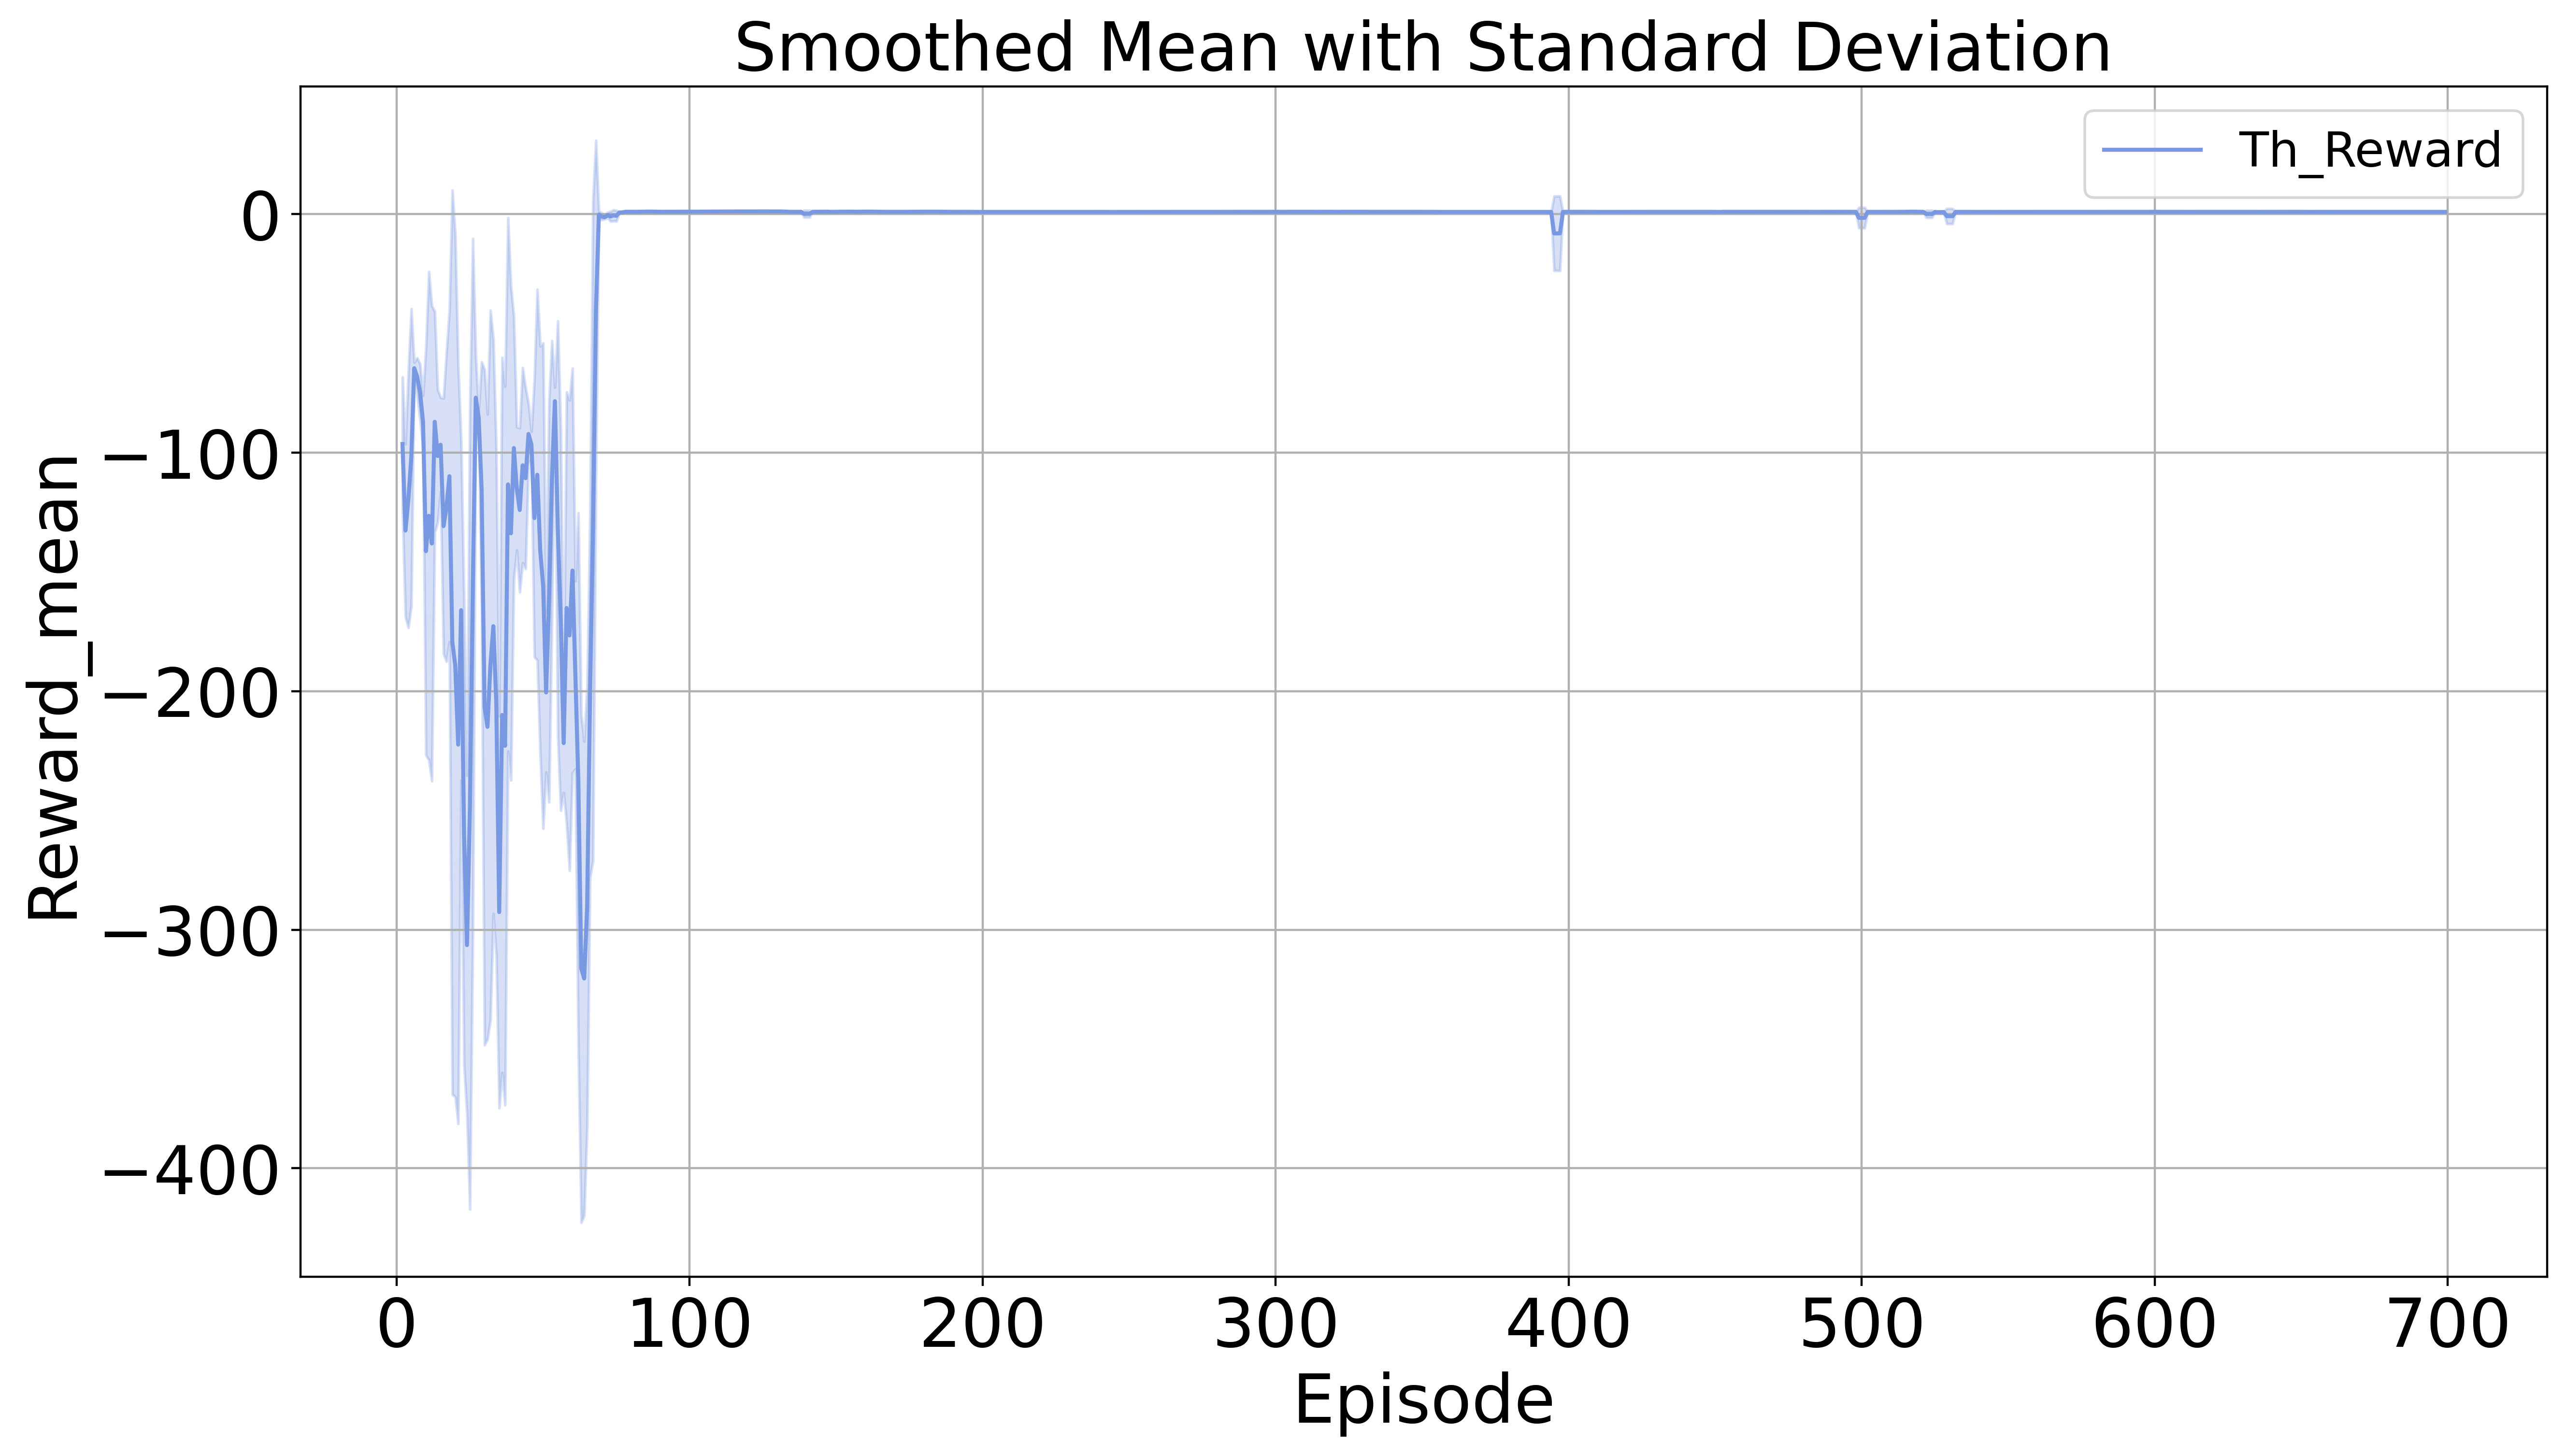

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
a=agent.actorloss
b=agent.criticloss
c=np.array(return_list)
# 生成一些随机数据
data = pd.Series(c)
# 计算滑动平均和标准差
rolling_mean = data.rolling(window=3).mean()
rolling_std = data.rolling(window=3).std()
# 绘制均值折线和标准差区间
plt.figure(figsize=(15,8),dpi=400)
# 设置刻度字体大小


plt.plot(rolling_mean, color='#7898e1',label='Th_Reward')
plt.fill_between(rolling_std.index, (rolling_mean-rolling_std).values, (rolling_mean+rolling_std).values, color='#7898e1', alpha=0.3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=25)
plt.ylabel(...,fontsize=25)
# 设置图例字体大小
plt.legend( fontsize=18)
# 添加标题和标签
plt.title('Smoothed Mean with Standard Deviation',fontsize=25)
plt.xlabel('Episode')
plt.ylabel('Reward_mean')
plt.grid(True)
plt.savefig('./TSTT/Reward-R.png',bbox_inches = 'tight')

plt.show()



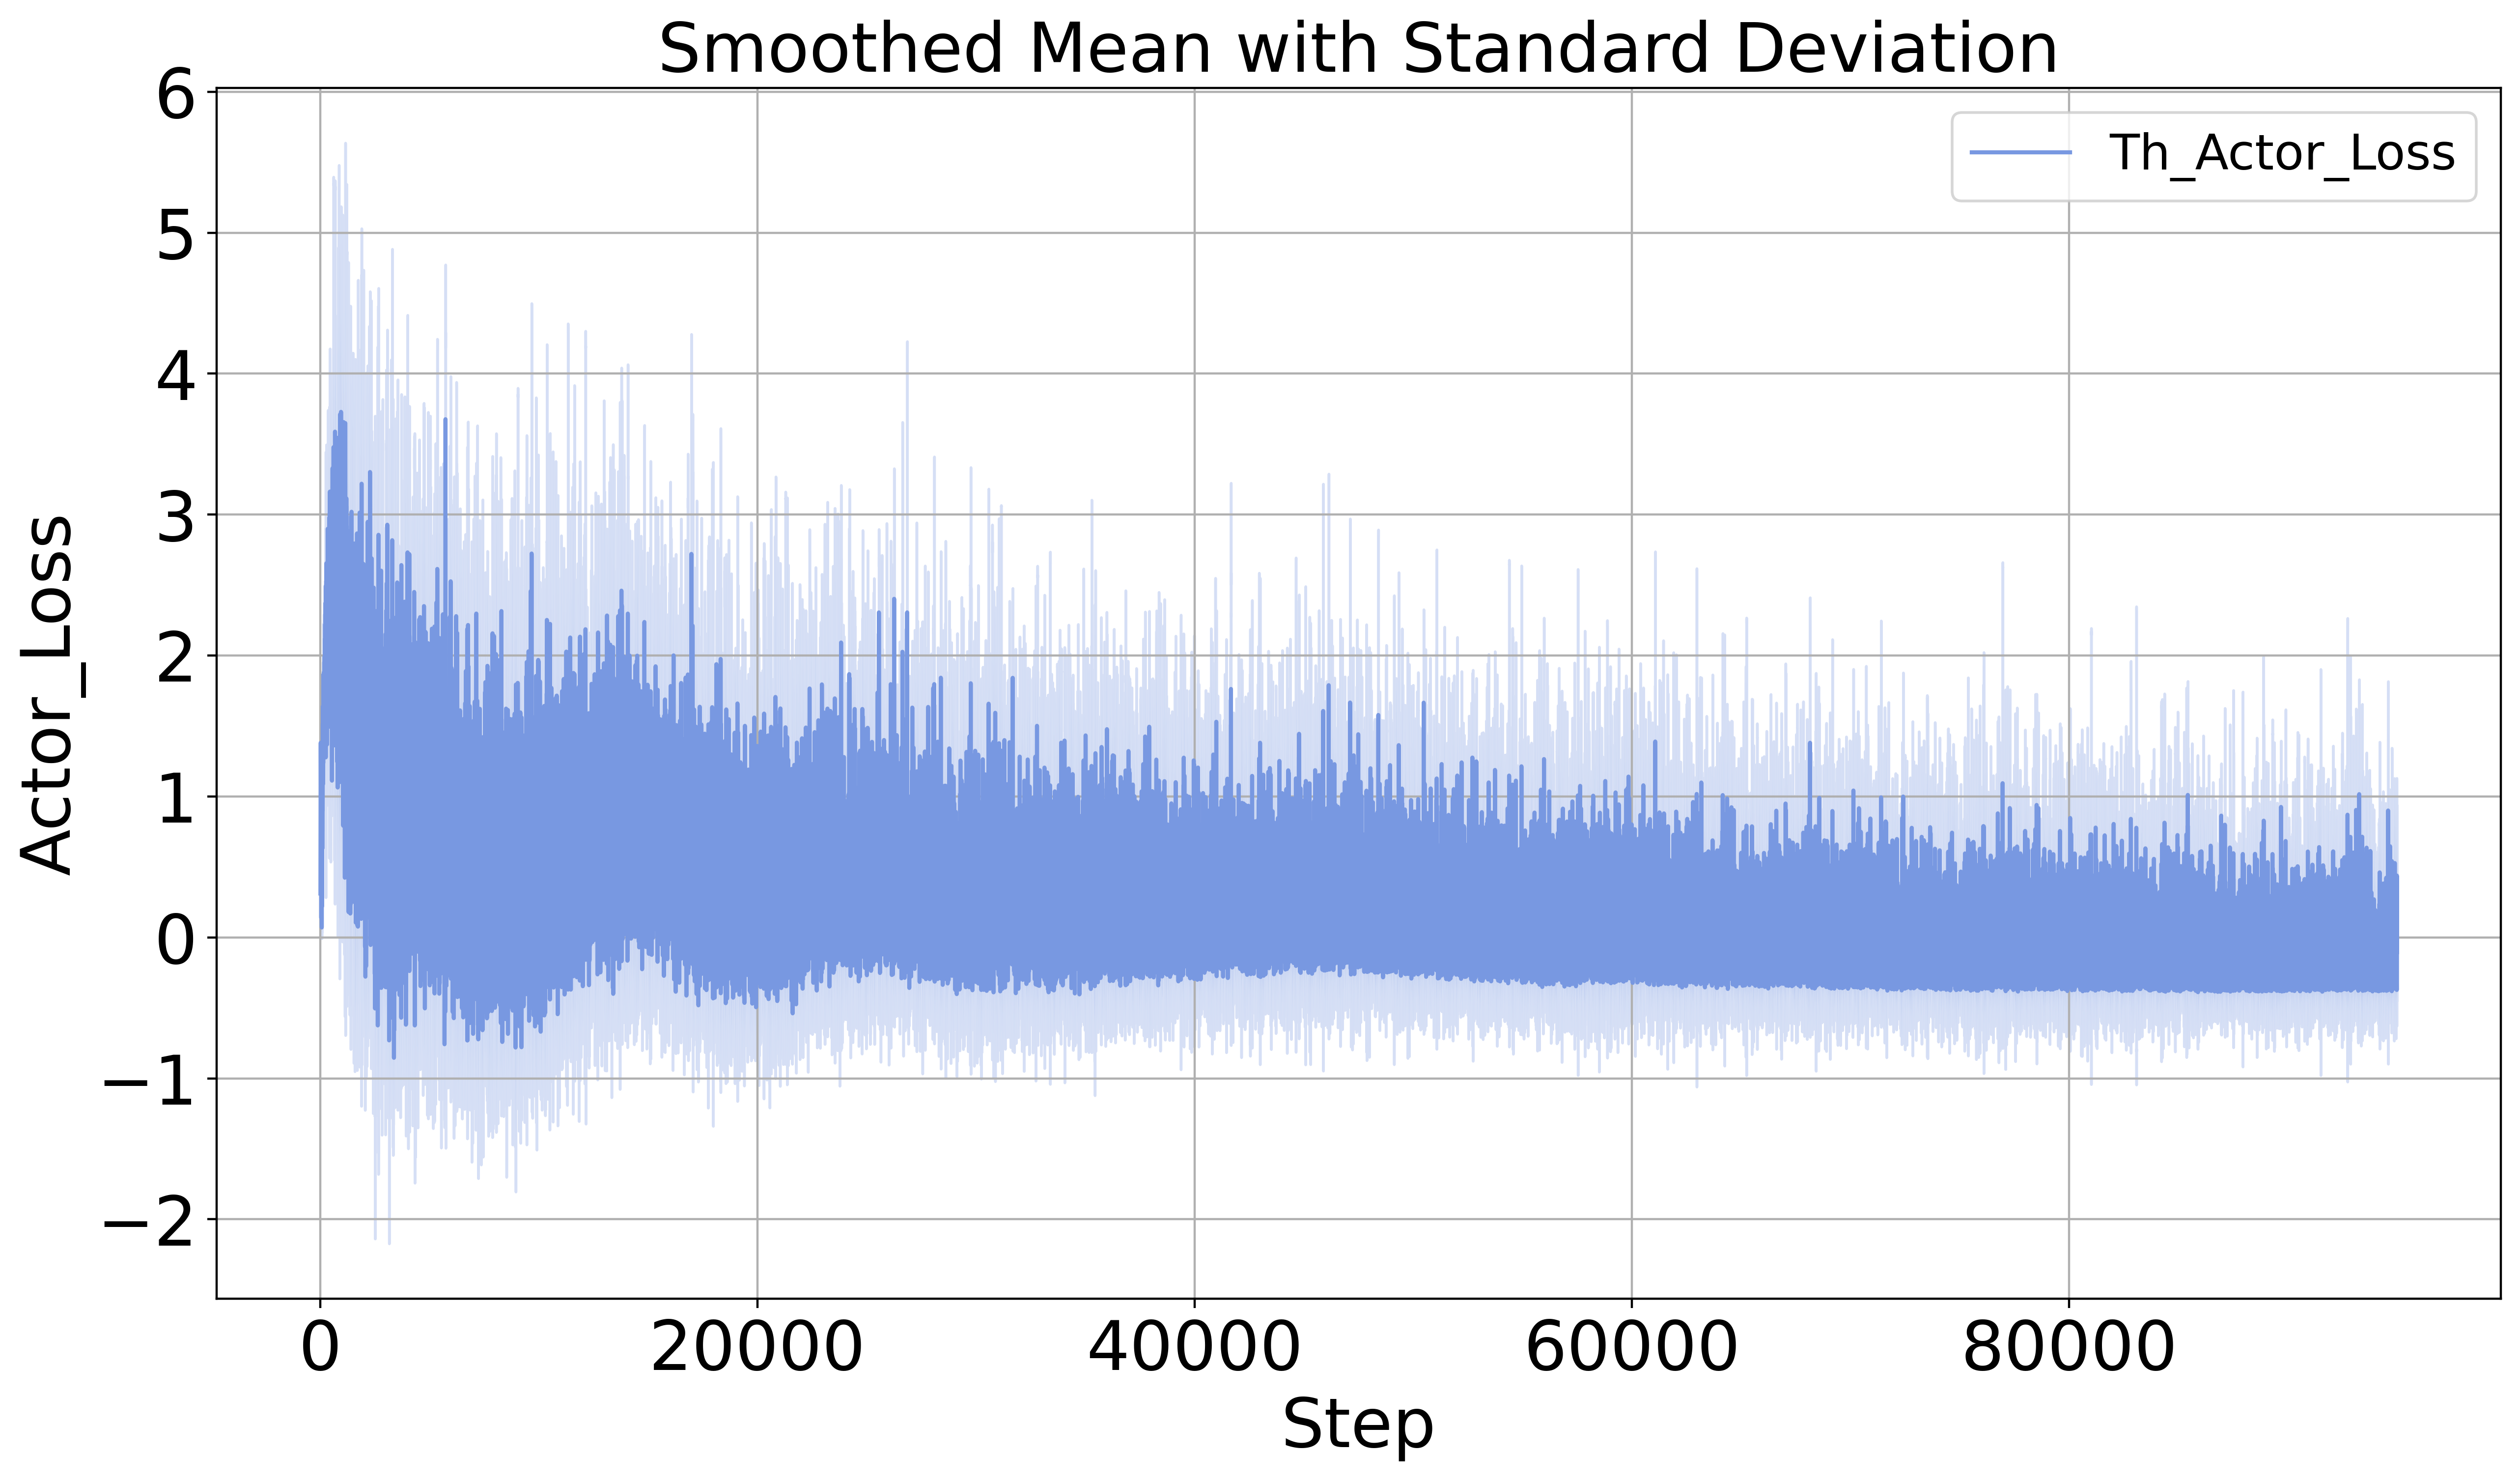

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
a=agent.actorloss
b=agent.criticloss
c=np.array(return_list)
# 生成一些随机数据
data = pd.Series(a)
# 计算滑动平均和标准差
rolling_mean = data.rolling(window=3).mean()
rolling_std = data.rolling(window=3).std()
# 绘制均值折线和标准差区间
plt.figure(figsize=(15,8),dpi=400)
# 设置刻度字体大小


plt.plot(rolling_mean, color='#7898e1',label='Th_Actor_Loss')
plt.fill_between(rolling_std.index, (rolling_mean-rolling_std).values, (rolling_mean+rolling_std).values, color='#7898e1', alpha=0.3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=25)
plt.ylabel(...,fontsize=25)
# 设置图例字体大小
plt.legend( fontsize=18)
# 添加标题和标签
plt.title('Smoothed Mean with Standard Deviation',fontsize=25)
plt.xlabel('Step')
plt.ylabel('Actor_Loss')
plt.grid(True)
plt.savefig('./TSTT/Actor_Loss.png',bbox_inches = 'tight')

plt.show()



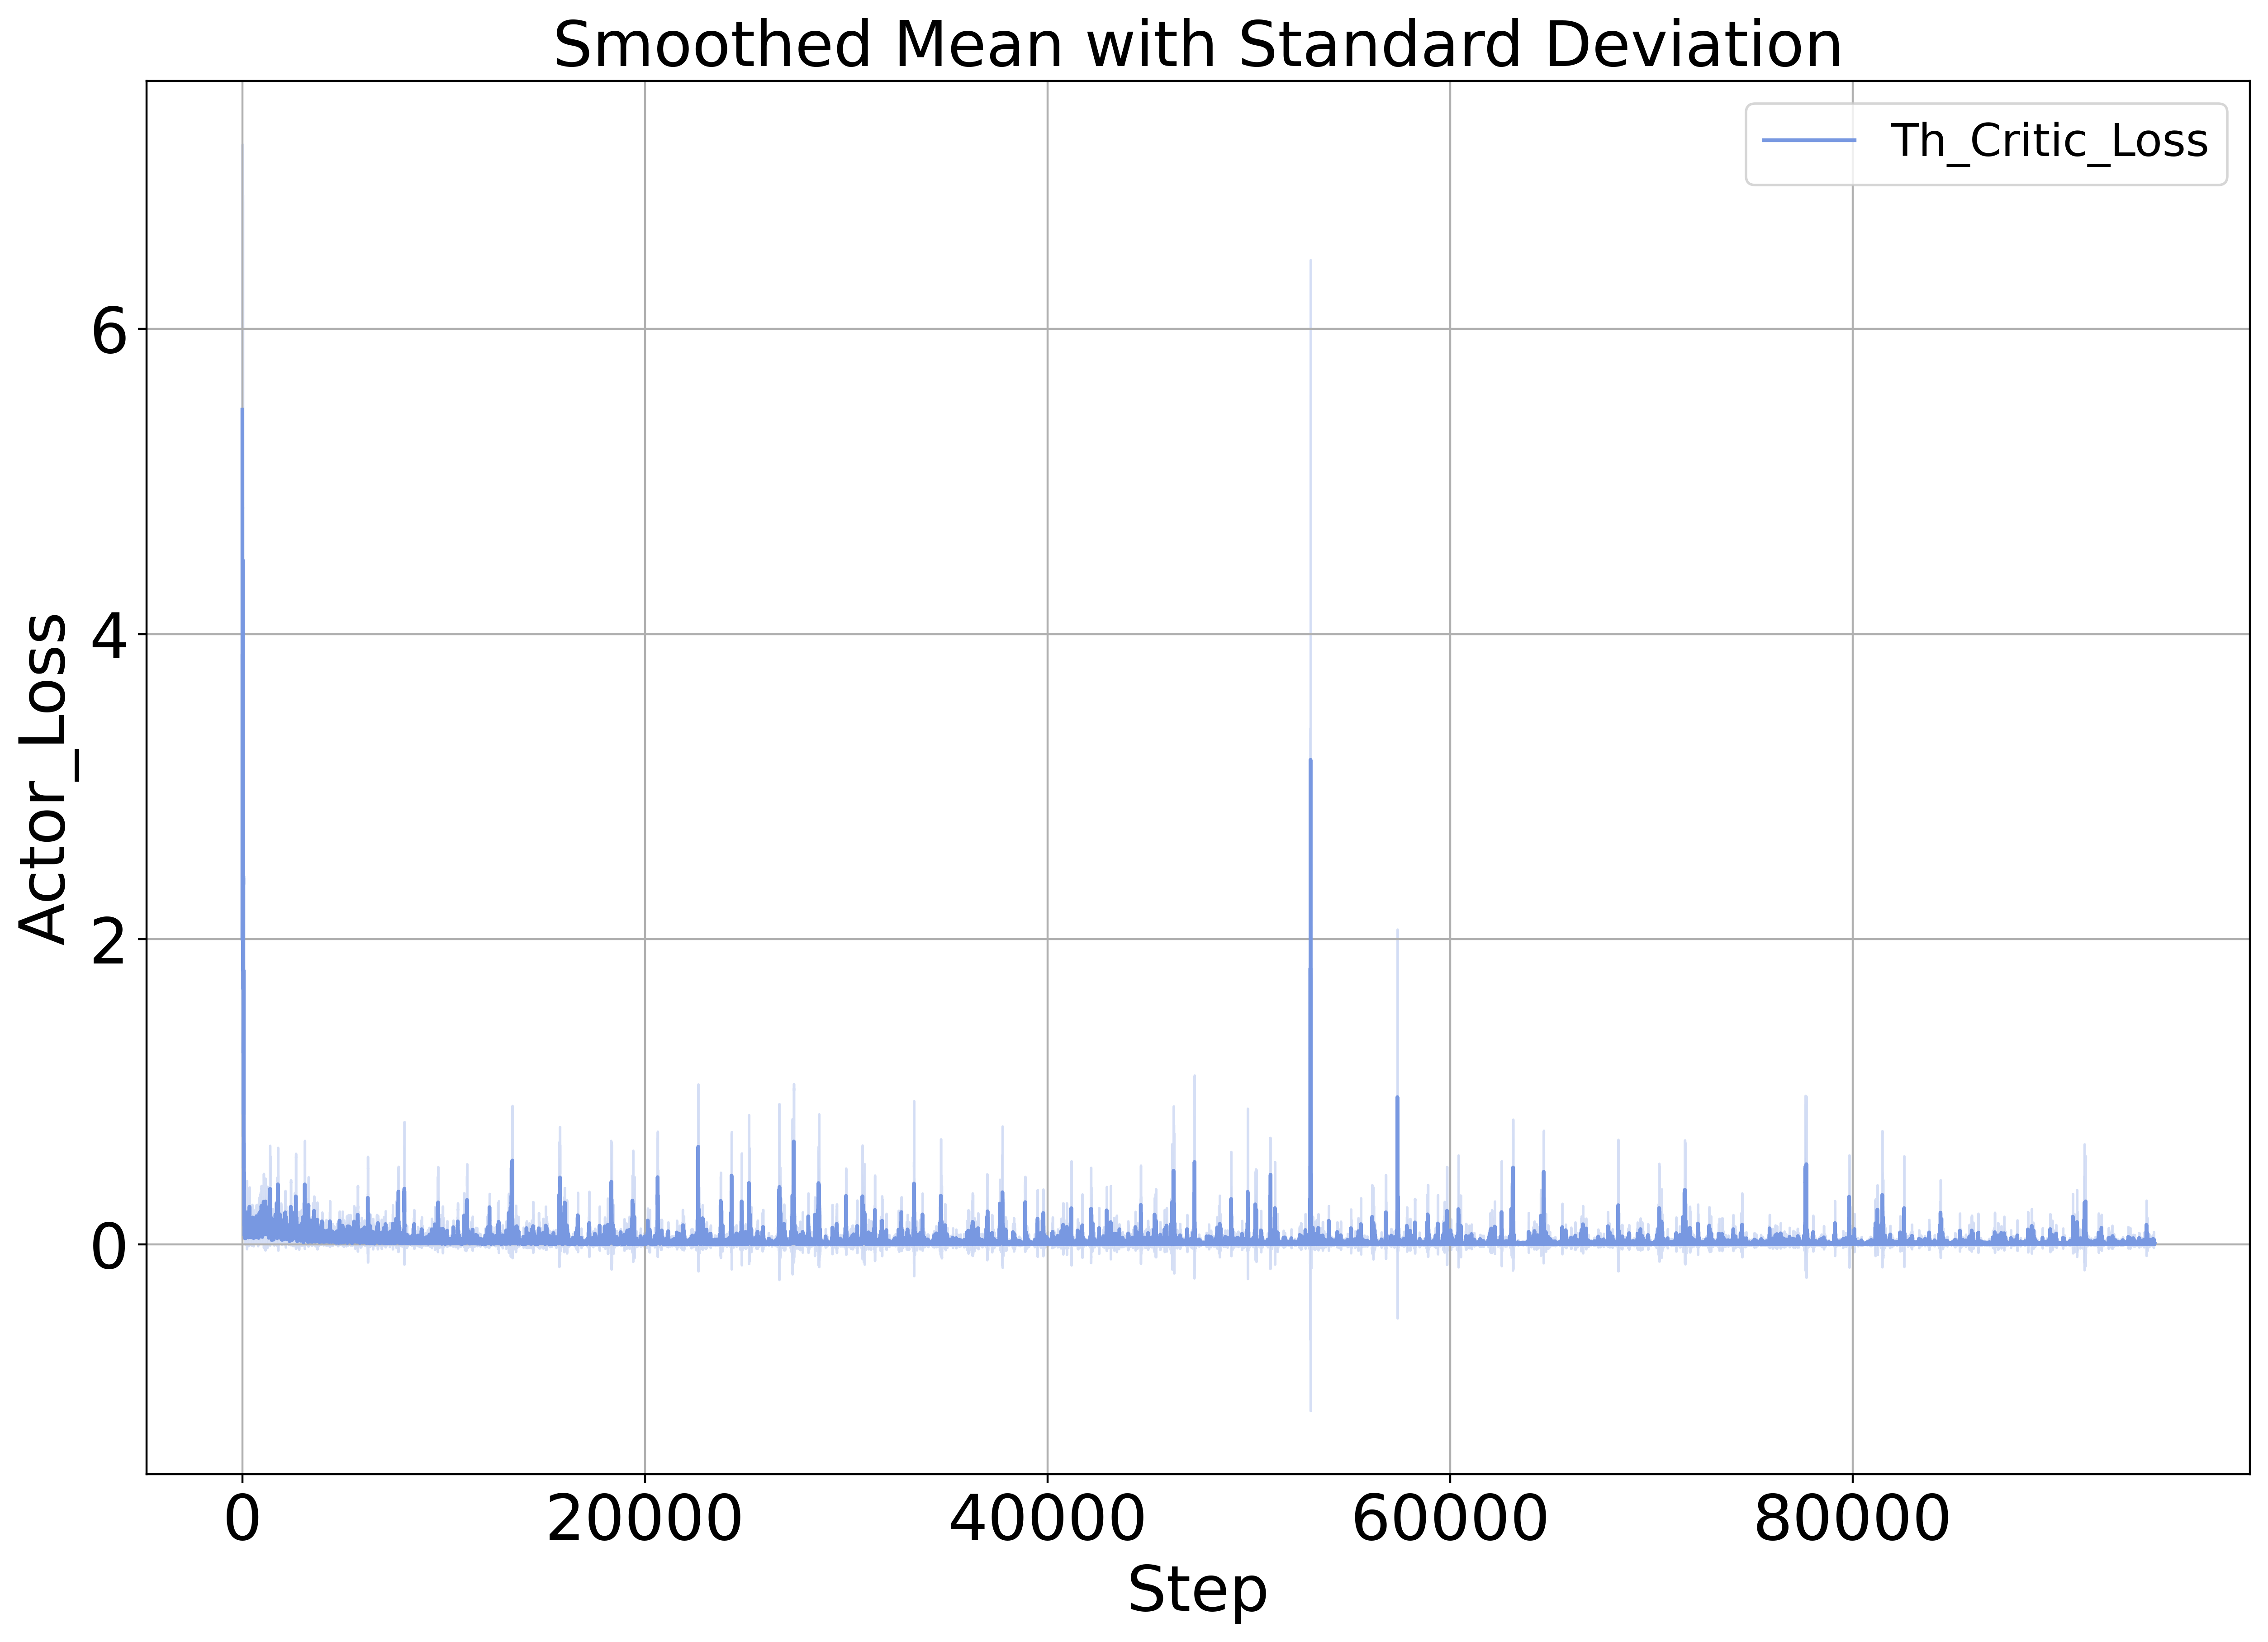

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
a=agent.actorloss
b=agent.criticloss
c=np.array(return_list)
# 生成一些随机数据
data = pd.Series(b)
# 计算滑动平均和标准差
rolling_mean = data.rolling(window=3).mean()
rolling_std = data.rolling(window=3).std()
# 绘制均值折线和标准差区间
plt.figure(figsize=(15,10),dpi=400)
# 设置刻度字体大小


plt.plot(rolling_mean, color='#7898e1',label='Th_Critic_Loss')
plt.fill_between(rolling_std.index, (rolling_mean-rolling_std).values, (rolling_mean+rolling_std).values, color='#7898e1', alpha=0.3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=25)
plt.ylabel(...,fontsize=25)
# 设置图例字体大小
plt.legend( fontsize=18)
# 添加标题和标签
plt.title('Smoothed Mean with Standard Deviation',fontsize=25)
plt.xlabel('Step')
plt.ylabel('Actor_Loss')
plt.grid(True)
plt.savefig('./TSTT/Critic_Loss.png',bbox_inches = 'tight')

plt.show()

